In [77]:
import jax.numpy as jnp
import jax
import equinox as eqx
from jaxtyping import PRNGKeyArray

from jax import Array
from jax.typing import ArrayLike
from typing import Optional


import cryojax as cx
import cryojax.simulator as cxs
import src.ensemble_sim as sim
import src.ensemble_sim_new as sim_new

from cryojax.image.operators import FourierGaussian
from cryojax.rotations import SO3
import dataclasses
import os
import jax_dataloader as jdl
from typing import Any, Callable, final
from typing_extensions import override

from cryojax.inference import distributions as dist


import matplotlib.pyplot as plt


import cryo_reweighting.optimization as optimization


In [78]:
@jax.jit
def grad_log_prob(weights: ArrayLike, likelihood: ArrayLike) -> Array:
    model = jnp.sum(likelihood*weights, axis=1)
    grad = jnp.mean(likelihood/model[:, jnp.newaxis], axis=0) 
    return grad

@jax.jit
def update_weights(weights: ArrayLike, grad: ArrayLike) -> Array:
    weights = weights*grad
    return weights

@jax.jit
def update_stats(weights: ArrayLike, likelihood: ArrayLike, true_weights):
    #TODO: other stats will go in here
    loss = -jnp.mean(jnp.log(jnp.sum(likelihood*weights, axis=1))) 
    entropy=  -jnp.sum(weights*jnp.log(weights))
    weights_error = jnp.sum(jax.scipy.special.kl_div(true_weights, weights))
    return loss, entropy, weights_error

def multiplicative_gradient(
    log_likelihood: ArrayLike,
    true_weights,
    tol: Optional[float] = 1e-8,
    max_iterations: Optional[float] = 100000,
    verbose: Optional[bool]=False,
    iter_freq: Optional[int] = 100
):

    num_images, num_structures = log_likelihood.shape

    # Initialize Weights
    weights = (1/num_structures)*jnp.ones(num_structures)

    # Subtracting the largest entry from each row of likelihood
    # The gradient is invariant to row scaling of likelihood, so this is valid
    # With this, we avoid working in log space for the grad and loss
    log_likelihood = log_likelihood - jnp.max(log_likelihood, 1)[:, jnp.newaxis]
    
    # NOTE: we cannot exponentiate this if previous step hasn't happened 
    likelihood = jnp.exp(log_likelihood)



    # Iterate
    stats = {}
    stats["loss"] = []
    stats["gap"] = []
    stats["entropy"] = []
    stats["weights"] = []
    stats["weights_idx"] = []
    stats["weights_error"] = []

    for k in range(max_iterations):

        # Update weights
        grad = grad_log_prob(weights, likelihood)   
        weights = update_weights(weights, grad)

        # update per iteration stats
        loss, entropy, weights_error = update_stats(weights, likelihood, true_weights)
                # Check stopping criterion: this `gap` is an upper bound on our loss compared to optimal weights
        gap = jnp.max(grad) - 1
        if k % iter_freq == 0: 
            if verbose:
                print(f"Number of iterations:{k}")
                print(f"Gap: {gap}") 
            stats["weights"].append(weights)
            stats["weights_idx"].append(k)
        if gap < tol:
            print(f"Number of iterations: {k}")
            print("exiting!")
            break

        stats["loss"].append(loss)
        stats["gap"].append(gap)
        stats["entropy"].append(entropy)
        stats["weights_error"].append(weights_error)


    stats["weights"] = jnp.stack(stats["weights"])
    stats["loss"] = jnp.stack(stats["loss"])
    stats["entropy"] = jnp.stack(stats["entropy"])
    stats["weights_idx"] = jnp.stack(stats["weights_idx"])
    stats["weights_error"] = jnp.stack(stats["weights_error"])
    stats["gap"] = jnp.stack(stats["gap"])

    return weights, stats

In [79]:
log_likelihood = jnp.load("log_likelihood_hsp90_10kimages_high_noise.npy")
true_weights = jnp.load("true_weights.npy")

import numpy as np
np.savetxt("log_likelihood_hsp90_10kimages_high_noise.txt", log_likelihood)

<BarContainer object of 20 artists>

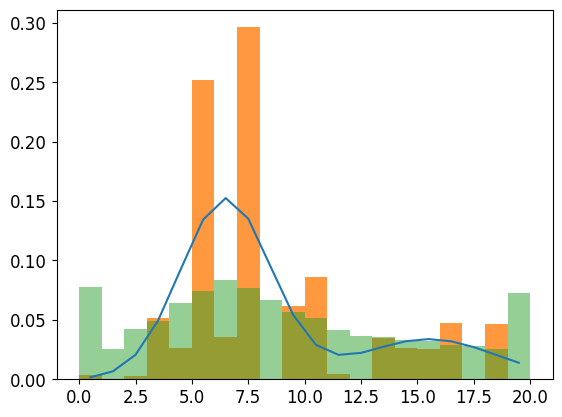

In [80]:
nodes = jnp.arange(0, 20, 1) + 0.5
x = jnp.argmax(log_likelihood, axis = 1)
hard_weights, _ = jnp.histogram(x, bins =jnp.arange(0, 21, 1))
hard_weights /= jnp.sum(hard_weights)
log_likelihood_aux = log_likelihood - jnp.max(log_likelihood, 1)[:, jnp.newaxis]
    
# NOTE: we cannot exponentiate this if previous step hasn't happened 
weights = (1/log_likelihood.shape[1])*jnp.ones(log_likelihood.shape[1])
likelihood = jnp.exp(log_likelihood_aux)
model = jnp.sum(likelihood*weights, axis=1)
grad = jnp.mean(likelihood/model[:, jnp.newaxis], axis=0) 
weights = weights*grad
softmax_weights, _ = multiplicative_gradient(log_likelihood, true_weights,max_iterations=1)

plt.plot(nodes, true_weights, label='true', color="C0")
ensemble_weights, stats = multiplicative_gradient(log_likelihood, true_weights)
plt.bar(nodes, ensemble_weights, 
        width=1, label='EM Weights', color="C1", alpha=0.8)
plt.bar(nodes, hard_weights, 
        width=1, label='EM Weights', color="C2", alpha=0.5)




In [81]:

weights_all = stats["weights"]
weights_idx = stats["weights_idx"]
losses = stats["loss"]
entropies = stats["entropy"]
weights_error = stats["weights_error"]
#plt.plot(nodes, true_weights, label='true', color="C0")
#plt.bar(nodes, ensemble_weights, 
#        width=1, label='EM Weights',  alpha=0.8)
#plt.bar(nodes, weights_all[3], 
#        width=1, label='EM Weights', alpha=0.8)





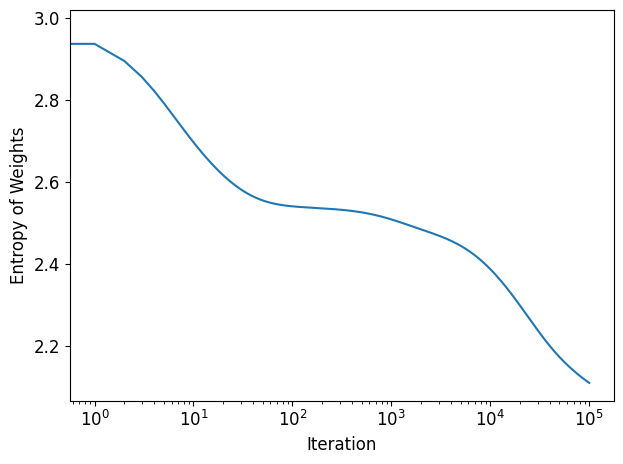

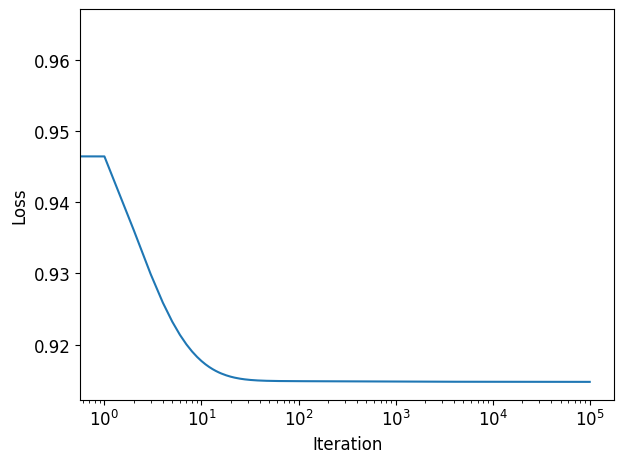

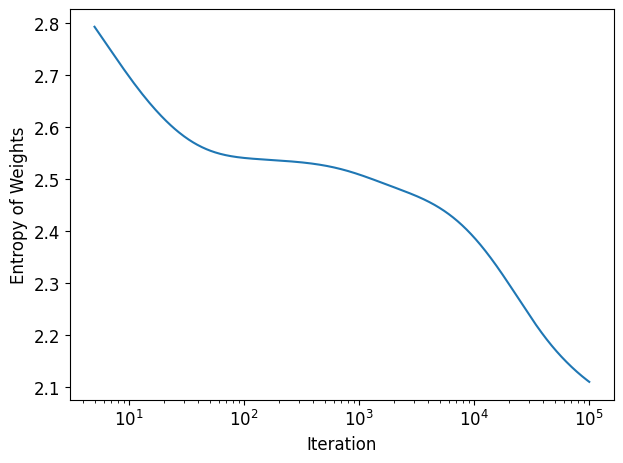

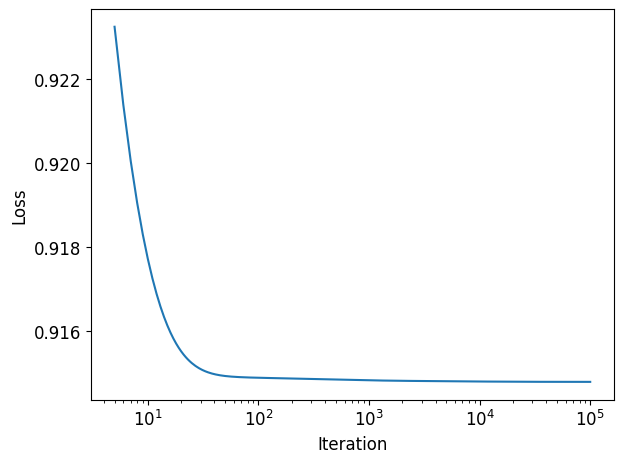

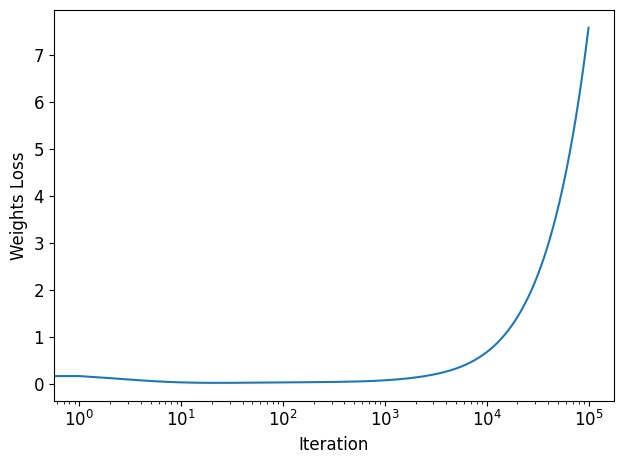

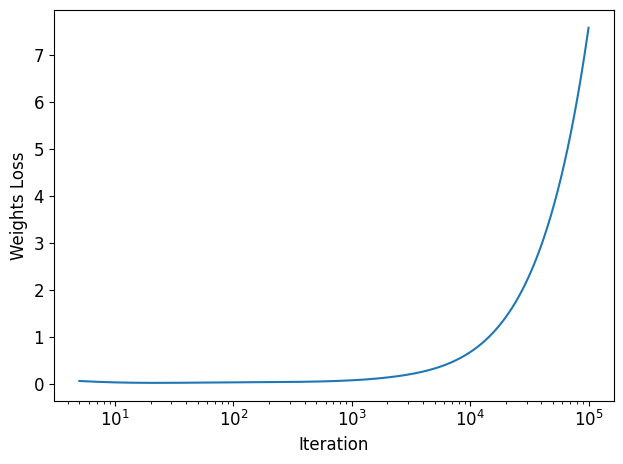

In [82]:
dir_name = "figures"
root = "high_noise"

plt.rcParams.update({'font.size': 12})

plt.figure()
plt.semilogx(entropies)
plt.ylabel("Entropy of Weights")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_entropy_{root}.png")

plt.figure()
plt.semilogx(losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_loss_{root}.png")

check_idx = 5
plt.figure()
plt.semilogx(np.arange(check_idx, len(entropies), 1), entropies[check_idx:])
plt.ylabel("Entropy of Weights")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_entropy_after_{check_idx}_{root}.png")

plt.figure()
plt.semilogx(np.arange(check_idx, len(losses), 1), losses[check_idx:])
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_loss_after_{check_idx}_{root}.png")

plt.figure()
plt.semilogx(weights_error)
plt.ylabel("Weights Loss")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_weights_error_{root}.png")

plt.figure()
plt.semilogx(np.arange(check_idx, len(weights_error), 1), weights_error[check_idx:])
plt.ylabel("Weights Loss")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_weights_error_{check_idx}_{root}.png")




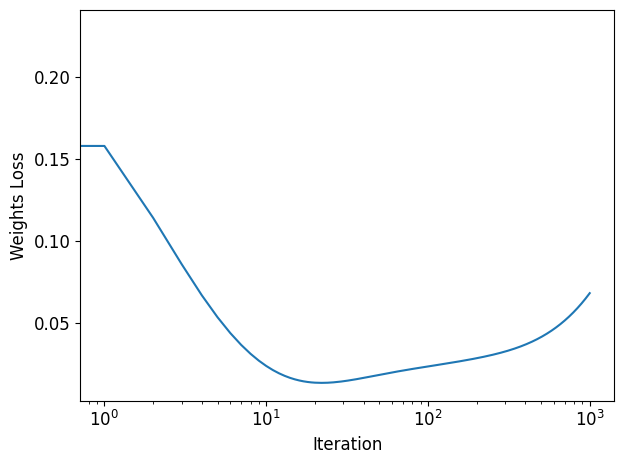

In [94]:
plt.figure()
plt.semilogx(weights_error[:1000])
plt.ylabel("Weights Loss")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig(f"{dir_name}/check_weights_error_{check_idx}_{root}_first5000.png")


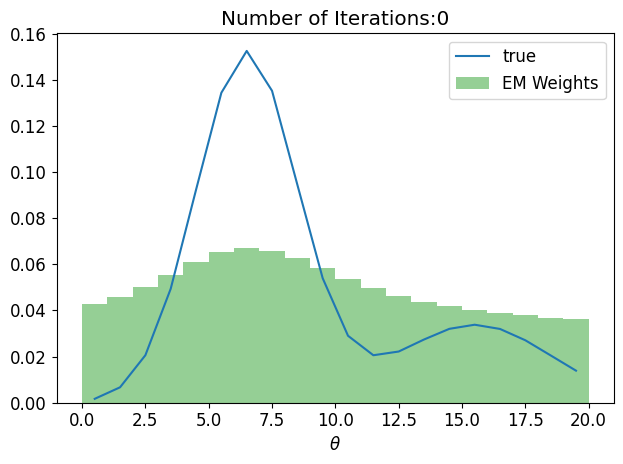

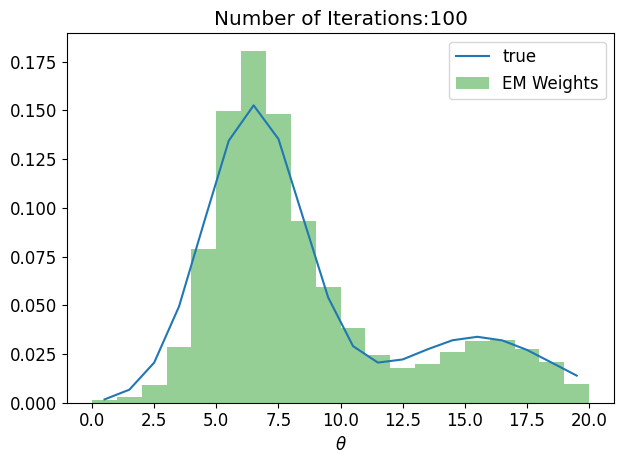

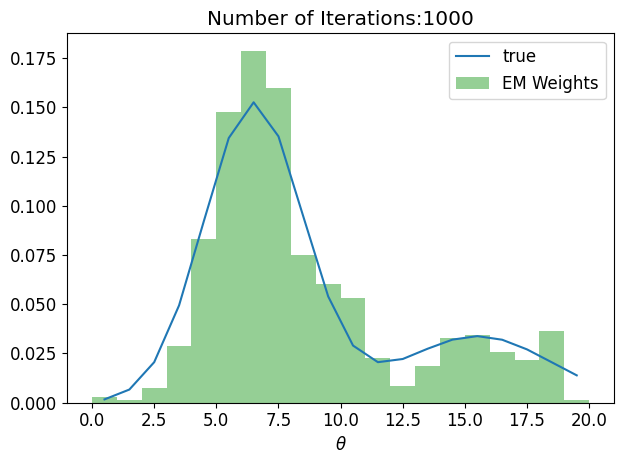

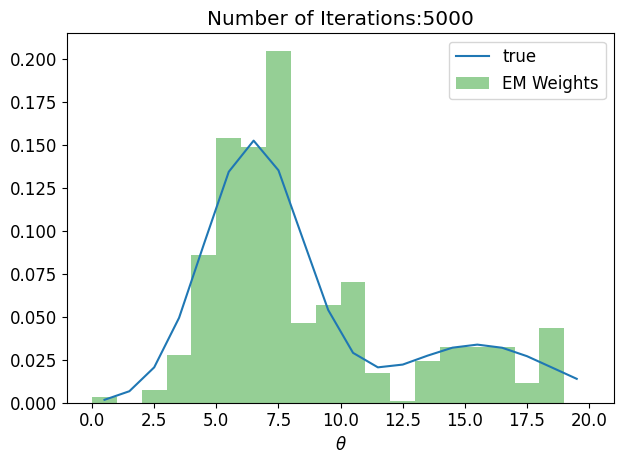

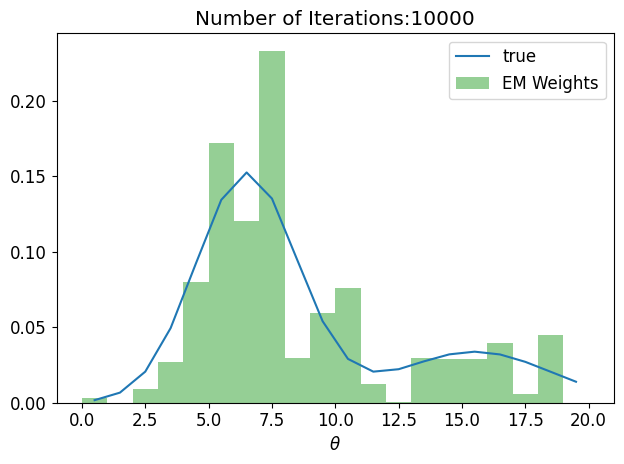

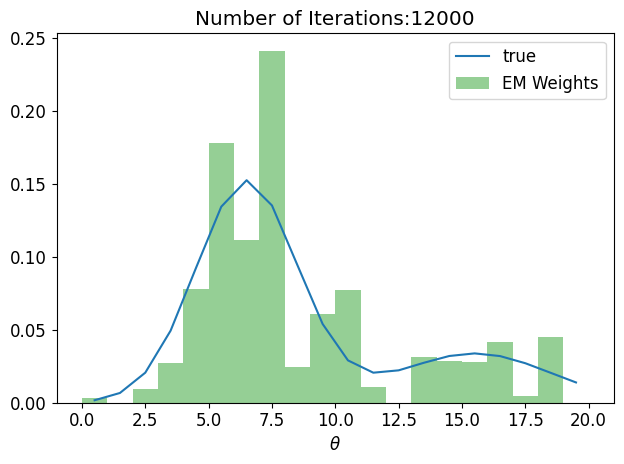

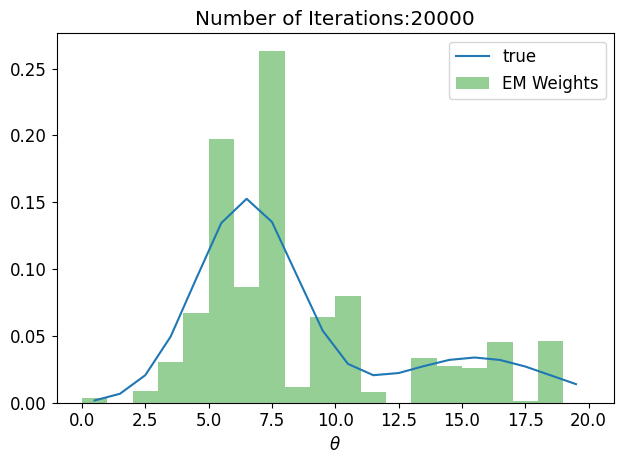

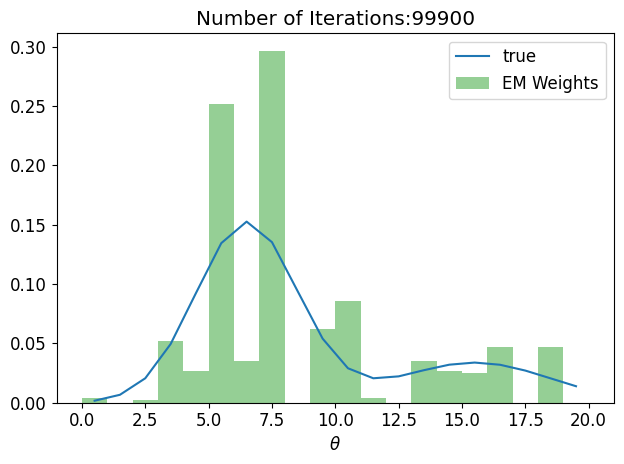

In [83]:
idx_list = [0, 1, 10, 50, 100, 120, 200, 1000]
for idx in idx_list:
    k = int(weights_idx[idx])
    #weights = saved_weights[idx, :]
    weights = weights_all[idx,:]
    fig, ax = plt.subplots()
    plt.plot(nodes, true_weights, label='true', color="C0")
    ax.bar(nodes, weights, 
        width=1, label='EM Weights', color="C2", alpha=0.5)

    ax.set_xlabel(r'$\theta$')
    ax.legend()
    plt.title(f"Number of Iterations:{k}")
    plt.tight_layout()
    plt.savefig(f"{dir_name}/weights_iter{k}_{root}.png", dpi=300)


# plotting against weights from mcmc

In [101]:
import csv

def calc_weights(directory, N_center):
    log_weights = []
    files = sorted(os.listdir(directory))[-8:]

    #log_weights_d = np.zeros((8, 10000, N_center), dtype=float)
    log_weights_d = np.zeros((8, 10000, N_center), dtype=float)
    i = 0
    for file in files:
        log_weights_chain = []
        with open('%s/%s'%(directory,file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,N_center+1)]
                log_weights_chain.append(log_weights_row)

        log_weights = np.array(log_weights_chain)
        log_weights_d[i,:,:] = log_weights
        i += 1

    log_weights_d -= jax.scipy.special.logsumexp(log_weights_d, axis=2)[:,:,None]
    #log_weights_d = log_weights_d[:, 0:100]

    weights_d = np.exp(log_weights_d)
    weights_d_mean = weights_d.mean((0,1))
    weights_d_std = weights_d.std((0,1))

    np.savetxt("weights_mean.txt", weights_d_mean, fmt='%.6f')
    np.savetxt("weights_std.txt", weights_d_std, fmt='%.6f')

calc_weights("/mnt/home/levans/Ensemble-reweighting-using-Cryo-EM-particles/src/cryoER/stan_output_other", 20)


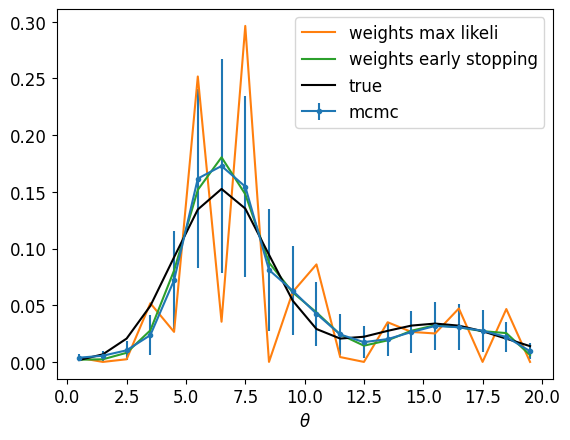

In [102]:
weights_mean = np.loadtxt("weights_mean.txt")
weights_std = np.loadtxt("weights_std.txt")
plt.figure()
plt.errorbar(nodes, weights_mean, weights_std, marker=".", label="mcmc")
plt.plot(nodes, weights, alpha=1, label="weights max likeli")
plt.plot(nodes, weights_all[3, :], alpha=1, label="weights early stopping")
plt.plot(nodes, true_weights, alpha=1, label="true", color="k")
#fname = f"figures/weights_errorbar_snr_idx_{i}_num_batches_idx_{j}.png"
plt.xlabel(r"$\theta$")
#plt.ylabel("p(index)")
plt.legend()
#plt.title(f"Weight error bar, SNR:{snr_val}, num_samples:{num_samples}, fontsize=22")
plt.savefig(f"{dir_name}/mcmc_and_maxlikeli.png", dpi=300)
#plt.close()



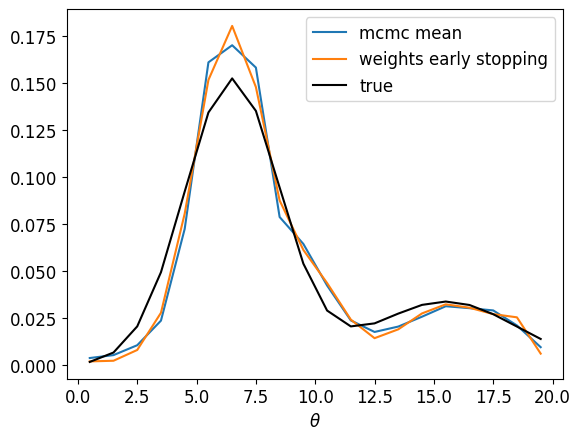

In [100]:
weights_mean = np.loadtxt("weights_mean.txt")
weights_std = np.loadtxt("weights_std.txt")
plt.figure()
#plt.errorbar(nodes, weights_mean, weights_std, marker=".", label="mcmc")
plt.plot(nodes, weights_mean, alpha=1, label="mcmc mean")
#plt.plot(nodes, weights, alpha=1, label="weights max likeli")
plt.plot(nodes, weights_all[3, :], alpha=1, label="weights early stopping")
plt.plot(nodes, true_weights, alpha=1, label="true", color="k")
#fname = f"figures/weights_errorbar_snr_idx_{i}_num_batches_idx_{j}.png"
plt.xlabel(r"$\theta$")
#plt.ylabel("p(index)")
plt.legend()
#plt.title(f"Weight error bar, SNR:{snr_val}, num_samples:{num_samples}, fontsize=22")
plt.savefig(f"{dir_name}/mcmc_and_maxlikeli.png", dpi=300)
#plt.close()

